In [24]:
from data_handling import DataHandling
import tkinter as tk
from tkinter import filedialog
from mmwave.dsp.range_processing import *   # pip install openradar
from mmwave.dsp.utils import *
from processing_chain import * 
import matplotlib.pyplot as plt



In [25]:
root = tk.Tk()
root.withdraw()

run_annotate = False
run_range_doppler_process = False
run_micro_doppler_process = True


In [26]:
if run_annotate:
    # specify radar params
    num_samples = 124
    num_chirps = 128
    num_tx = 1
    num_rx = 4
    frames_per_second = 20

    annotate_captured_data(num_samples, num_chirps, num_tx, num_rx, frames_per_second)
else:
    # get file and radar parameters
    file_path = filedialog.askdirectory(initialdir='/mnt/c/work/rcube_extract/dca_capture/captured_data')
    print(file_path)
    # file_path = '/mnt/c/work/rcube_extract/dca_capture/captured_data/dca_mar31_1825_trx14_n122xp128_fps20_walk_parade' # for debugging 
    dir_name = file_path.split("/")[-1]
    params = dir_name.split('_')

    num_samples = int(params[4].split('x')[0][1:])
    num_chirps = int(params[4].split('x')[1][1:])
    num_tx = int(params[3][3])
    num_rx = int(params[3][4])
    frames_per_second = int(params[5][3:])

    dh = DataHandling(num_samples, num_chirps, num_tx, num_rx, frames_per_second)

/mnt/c/work/rcube_extract/dca_capture/captured_data/dca_apr16_0104_trx14_n111xp128_fps20_test


In [27]:
if run_range_doppler_process:
    dh.range_doppler_process(file_path)

In [29]:
if run_micro_doppler_process:
    raw_data = dh.raw_data_cube(file_path)
    print(type(raw_data))

    # implement micro-doppler processing
    data_status = True
    # range-doppler proessing of the raw data
    axis_range = 0

    micro_doppler_spectrum = np.zeros((128,0))

    while data_status:
        data_cube = next(raw_data, [])
        
        if len(data_cube) == 0:
            break 

        # (1) perform range-fft and sum over range axis
        data_cube_fft1 = range_processing(data_cube, window_type_1d=Window.HAMMING, axis=axis_range)
        data_range_accum = np.sum(data_cube_fft1, axis=axis_range)
        print(data_range_accum.shape)

        # (2) perform doppler-fft 
        axis_doppler = 0 # since range_axis is removed
        micro_doppler = doppler_processing_custom(data_range_accum, num_tx=1, clutter_removal_enabled=True, 
        interleaved=False, window_type_2d=Window.HAMMING, accumulate=False, axis=axis_doppler)
        micro_doppler_ch1 = np.abs(micro_doppler[:,0,:])
        print('dimensions:' + str(micro_doppler_ch1.shape))
        micro_doppler_spectrum = np.append(micro_doppler_spectrum, micro_doppler_ch1, axis=1)
        print('md dimensions:' + str(micro_doppler_spectrum.shape))

        data_status = np.size(data_cube)

<class 'generator'>
file index: 0 | datacube shape(111, 128, 4, 284)
(128, 4, 284)
dimensions:(128, 284)
md dimensions:(128, 284)
file index: 1 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensions:(128, 569)
file index: 2 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensions:(128, 854)
file index: 3 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensions:(128, 1139)
file index: 4 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensions:(128, 1424)
file index: 5 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensions:(128, 1709)
file index: 6 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensions:(128, 1994)
file index: 7 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensions:(128, 2279)
file index: 8 | datacube shape(111, 128, 4, 285)
(128, 4, 285)
dimensions:(128, 285)
md dimensi

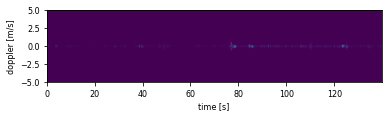

In [35]:
save_path = '/mnt/c/work/rcube_extract/dca_capture/micro_doppler/'
save_file = save_path + dir_name + '_test.jpg'       

plt.rcParams.update({'font.size':8})

max_velocity = 5

plt.xlabel('time [s]')
plt.ylabel('doppler [m/s]')
plt.imshow(micro_doppler_spectrum, aspect=3, extent=[0, micro_doppler_spectrum.shape[1]/frames_per_second, -max_velocity, max_velocity] )
#plt.xlim(0, micro_doppler_spectrum.shape[1]/frames_per_second)
#plt.ylim((6, -6))
#plt.savefig(save_file)
plt.savefig(save_file, dpi=1000, bbox_inches = 'tight', pad_inches = 0)
plt.show()
